In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import pickle
from collections import Counter

C:\Users\usha kiran.k\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def tokenize_code(code):
    return re.findall(r'\w+|\S', str(code))

def build_vocab(all_codes, max_vocab_size=10000):
    counter = Counter()
    for code in all_codes:
        tokens = tokenize_code(code)
        counter.update(tokens)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (token, _) in enumerate(counter.most_common(max_vocab_size - 2), 2):
        vocab[token] = i

    # Save vocab for later use
    with open("vocab.pkl", "wb") as f:
        pickle.dump(vocab, f)

    return vocab

def encode_code(code, vocab, max_length=300):
    tokens = tokenize_code(code)
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return indices[:max_length]

In [3]:
class CodeDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length=300):
        self.codes = dataframe['code'].tolist()
        self.labels = dataframe['label'].tolist()
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.codes)

    def __getitem__(self, idx):
        code = self.codes[idx]
        label = self.labels[idx]
        encoded = encode_code(code, self.vocab, self.max_length)
        return torch.tensor(encoded), torch.tensor(label)

def pad_collate(batch):
    codes, labels = zip(*batch)
    padded_codes = nn.utils.rnn.pad_sequence(codes, batch_first=True, padding_value=0)
    return padded_codes, torch.tensor(labels)


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

In [10]:
def train_model(model, train_loader, val_loader=None, epochs=30, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.long(), y_batch.float().unsqueeze(1)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}")

    # Plot only training loss
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()



In [11]:
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.long()
            preds = model(x_batch).squeeze()
            preds = torch.round(preds)
            y_pred.extend(preds.tolist())
            y_true.extend(y_batch.tolist())

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"\nAccuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1 Score: {f1:.4f}")


Epoch 1 | Train Loss: 0.6969
Epoch 2 | Train Loss: 0.6601
Epoch 3 | Train Loss: 0.6411
Epoch 4 | Train Loss: 0.6220
Epoch 5 | Train Loss: 0.6042
Epoch 6 | Train Loss: 0.5853
Epoch 7 | Train Loss: 0.5643
Epoch 8 | Train Loss: 0.5384
Epoch 9 | Train Loss: 0.5295
Epoch 10 | Train Loss: 0.5099
Epoch 11 | Train Loss: 0.5146
Epoch 12 | Train Loss: 0.5333
Epoch 13 | Train Loss: 0.5074
Epoch 14 | Train Loss: 0.4668
Epoch 15 | Train Loss: 0.4698
Epoch 16 | Train Loss: 0.4649
Epoch 17 | Train Loss: 0.4605
Epoch 18 | Train Loss: 0.4352
Epoch 19 | Train Loss: 0.4352
Epoch 20 | Train Loss: 0.4271
Epoch 21 | Train Loss: 0.4350
Epoch 22 | Train Loss: 0.4401
Epoch 23 | Train Loss: 0.5188
Epoch 24 | Train Loss: 0.4752
Epoch 25 | Train Loss: 0.4495
Epoch 26 | Train Loss: 0.4409
Epoch 27 | Train Loss: 0.4365
Epoch 28 | Train Loss: 0.4268
Epoch 29 | Train Loss: 0.4169
Epoch 30 | Train Loss: 0.4188


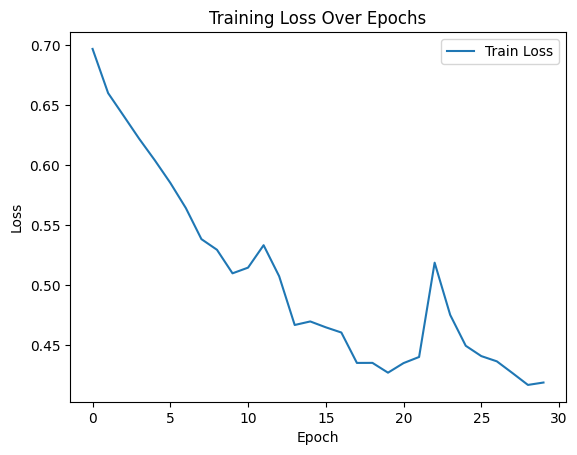


--- Test Evaluation ---

Accuracy: 0.5254 | Precision: 0.5283 | Recall: 0.6000 | F1 Score: 0.5619


In [12]:
def main():
    # Load CSVs (update paths if needed)
    train_df = pd.read_csv("D:/vulnerability_dataset_processed.csv")
    val_df = pd.read_csv("D:/Validation_Dataset.csv")
    test_df = pd.read_csv("D:/Test_dataset.csv")

    # Build vocab from train only
    vocab = build_vocab(train_df['code'])

    # Dataset and DataLoader
    train_data = CodeDataset(train_df, vocab)
    val_data = CodeDataset(val_df, vocab)
    test_data = CodeDataset(test_df, vocab)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_collate)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=pad_collate)

    # Model
    model = RNNClassifier(vocab_size=len(vocab))

    # Train
    train_model(model, train_loader, val_loader)
    # Evaluate
    print("\n--- Test Evaluation ---")
    evaluate_model(model, test_loader)

if __name__ == "__main__":
    main()
